<a href="https://colab.research.google.com/github/Breysel/HexAI/blob/reinforcement-learning-AI/hexAIputer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import time
from collections import deque, namedtuple
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam


In [6]:
# Set the random seed for TensorFlow
SEED = 0
random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
# Hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## State Space
The state space is defined by the board state:
Example of a board with 9 fields pegholes:
[[0, 0, 0, 0, 1, 0, 0, -1, 0]]
-1 means stone of the opponent
1 means the AI's stone
0 means no stone


## Action Space
For a board with i fields, possible actions are 0, 1, 2, ..., i-1

# Rewards
* 1000 for a won game
* -1000 for a lost game
* Illegal move: -1000 for an illegal move (everytime the AI wants to put a stone on an existing stone it get's slapped - learn the rules, dorothy!)

### What happens if the AI suggests an illegal move
Besides the negative reward:
* To make sure the game continues a random legal move will be placed instead (not sure yet if that should happen here, or  in the Hex file)





In [12]:
# Deep Q-Learning with target network Q^
# that will be updated slower to avoid oszilations in the target space

state_size = 9 #at some point this should be done more flexible

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(64, activation = 'relu', name = 'L1'),
    Dense(64,activation = 'relu', name = 'L2'),
    Dense(state_size, activation = 'linear', name = 'L3')
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(64, activation = 'relu', name = 'L1'),
    Dense(64,activation = 'relu', name = 'L2'),
    Dense(state_size, activation = 'linear', name = 'L3')
    ])

optimizer = Adam(learning_rate=ALPHA)


In [13]:
# look at da shit
q_network.summary()
target_q_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 64)                640       
                                                                 
 L2 (Dense)                  (None, 64)                4160      
                                                                 
 L3 (Dense)                  (None, 9)                 585       
                                                                 
Total params: 5385 (21.04 KB)
Trainable params: 5385 (21.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 64)                640       
                                                                 


# Experience Replay
When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as Experience Replay to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples  (𝑆𝑡,𝐴𝑡,𝑅𝑡,𝑆𝑡+1)
  will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.


In [14]:
# Experience Replay
# Store 'experiences' as named tuples
# fuck my life knows why (the tuple thing)
# more efficient/ less space or something
# not sure yet, if we really need reward and done in there
experience = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])

# Error of the loss function
(that will be minimized via gradient descent)

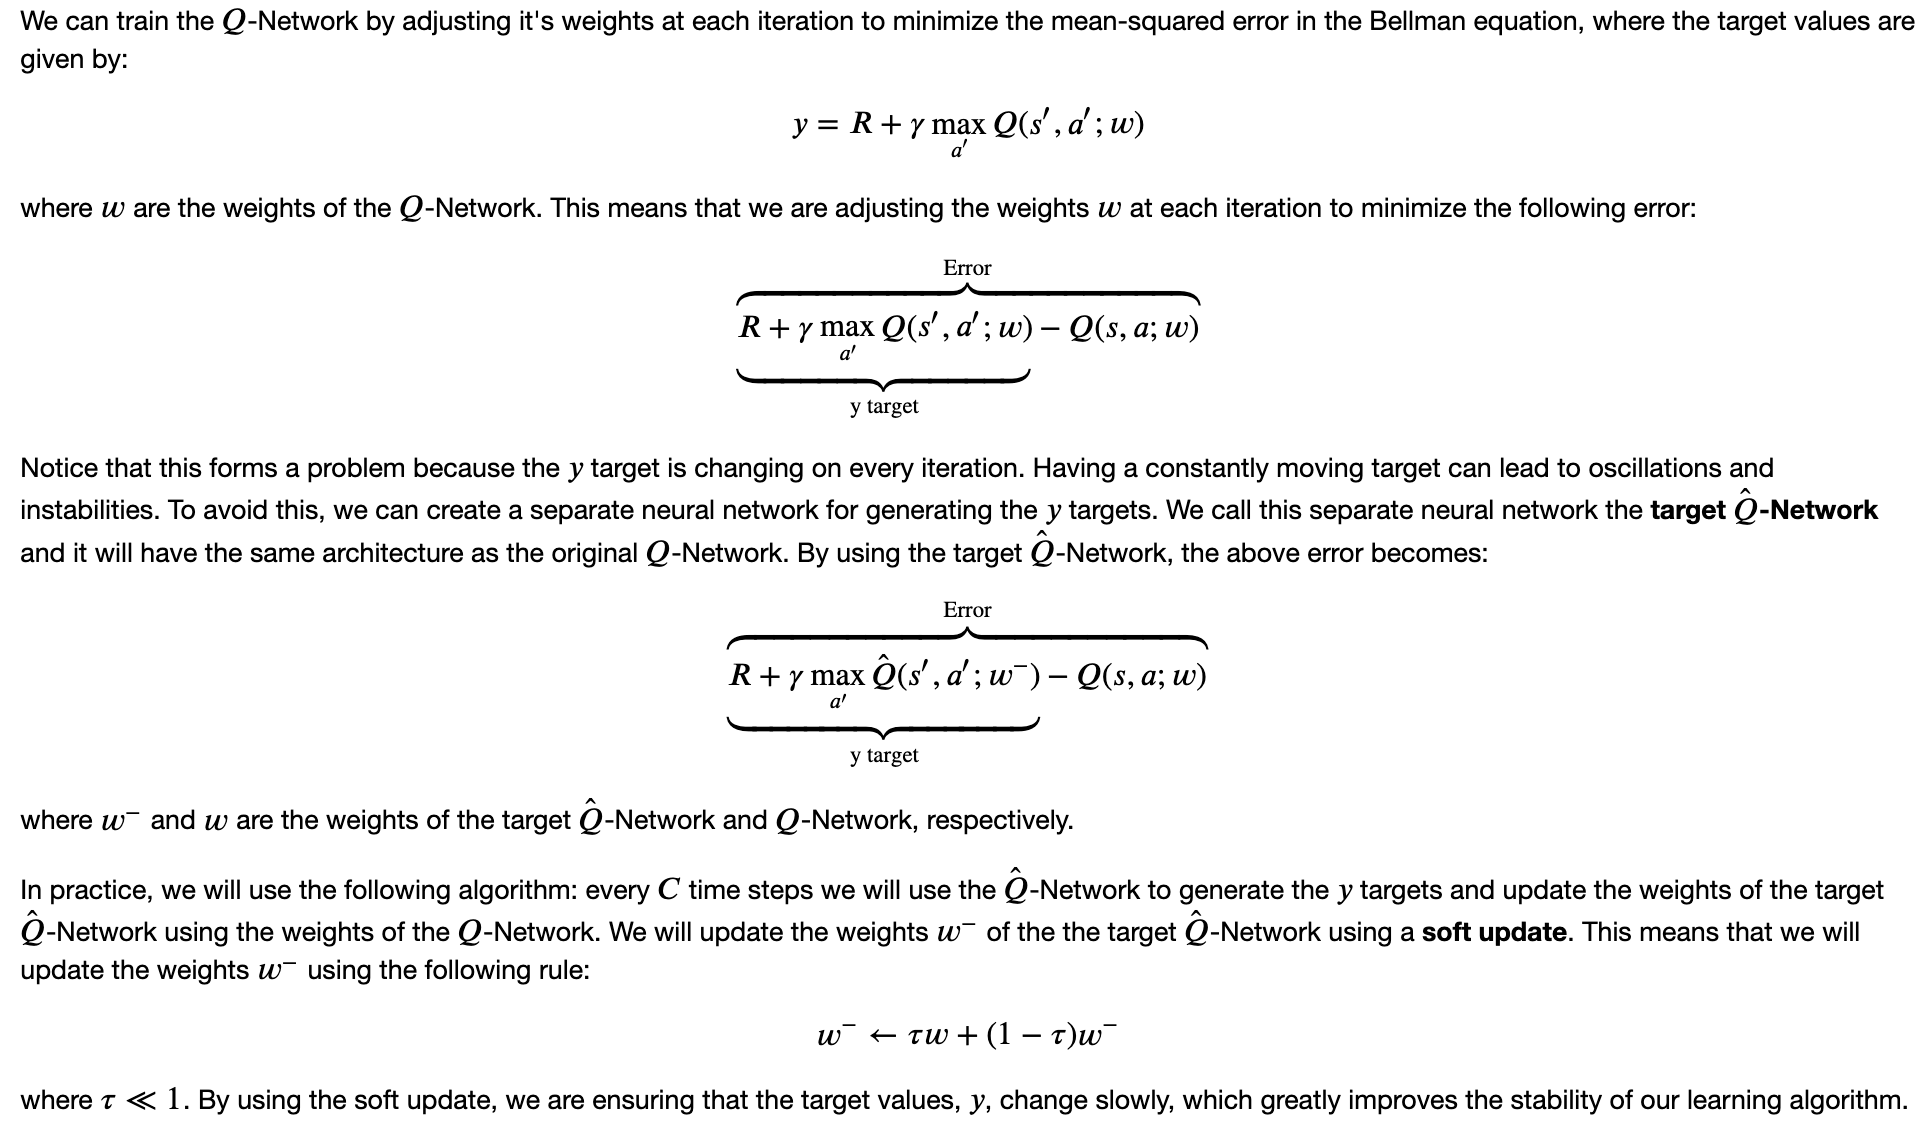


In [15]:
# Lossfunction

def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + gamma*(1-done_vals)*max_qsa

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    loss = MSE(y_targets,q_values)

    return loss

In [18]:
@tf.function #no idea what this does - but it works

def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [20]:
# functions that we'll need in the training

def get_action(q_values, epsilon=0.0):
    """
    Returns an action using an ε-greedy policy.

    This function will return an action according to the following rules:
        - With probability epsilon, it will return an action chosen at random.
        - With probability (1 - epsilon), it will return the action that yields the
        maximum Q value in q_values.

    Args:
        q_values (tf.Tensor):
            The Q values returned by the Q-Network. For the Lunar Lander environment
            this TensorFlow Tensor should have a shape of [1, 4] and its elements should
            have dtype=tf.float32.
        epsilon (float):
            The current value of epsilon.

    Returns:
       An action (numpy.int64).
    """

    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))

def check_update_conditions(t, num_steps_upd, memory_buffer):
    """
    Determines if the conditions are met to perform a learning update.

    Checks if the current time step t is a multiple of num_steps_upd and if the
    memory_buffer has enough experience tuples to fill a mini-batch (for example, if the
    mini-batch size is 64, then the memory buffer should have more than 64 experience
    tuples in order to perform a learning update).

    Args:
        t (int):
            The current time step.
        num_steps_upd (int):
            The number of time steps used to determine how often to perform a learning
            update. A learning update is only performed every num_steps_upd time steps.
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
       A boolean that will be True if conditions are met and False otherwise.
    """

    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_experiences(memory_buffer):
    """
    Returns a random sample of experience tuples drawn from the memory buffer.

    Retrieves a random sample of experience tuples from the given memory_buffer and
    returns them as TensorFlow Tensors. The size of the random sample is determined by
    the mini-batch size (MINIBATCH_SIZE).

    Args:
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
        A tuple (states, actions, rewards, next_states, done_vals) where:

            - states are the starting states of the agent.
            - actions are the actions taken by the agent from the starting states.
            - rewards are the rewards received by the agent after taking the actions.
            - next_states are the new states of the agent after taking the actions.
            - done_vals are the boolean values indicating if the episode ended.

        All tuple elements are TensorFlow Tensors whose shape is determined by the
        mini-batch size and the given Gym environment. For the Lunar Lander environment
        the states and next_states will have a shape of [MINIBATCH_SIZE, 8] while the
        actions, rewards, and done_vals will have a shape of [MINIBATCH_SIZE]. All
        TensorFlow Tensors have elements with dtype=tf.float32.
    """

    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)


def get_new_eps(epsilon):
    """
    Updates the epsilon value for the ε-greedy policy.

    Gradually decreases the value of epsilon towards a minimum value (E_MIN) using the
    given ε-decay rate (E_DECAY).

    Args:
        epsilon (float):
            The current value of epsilon.

    Returns:
       A float with the updated value of epsilon.
    """

    return max(E_MIN, E_DECAY * epsilon)

# Training

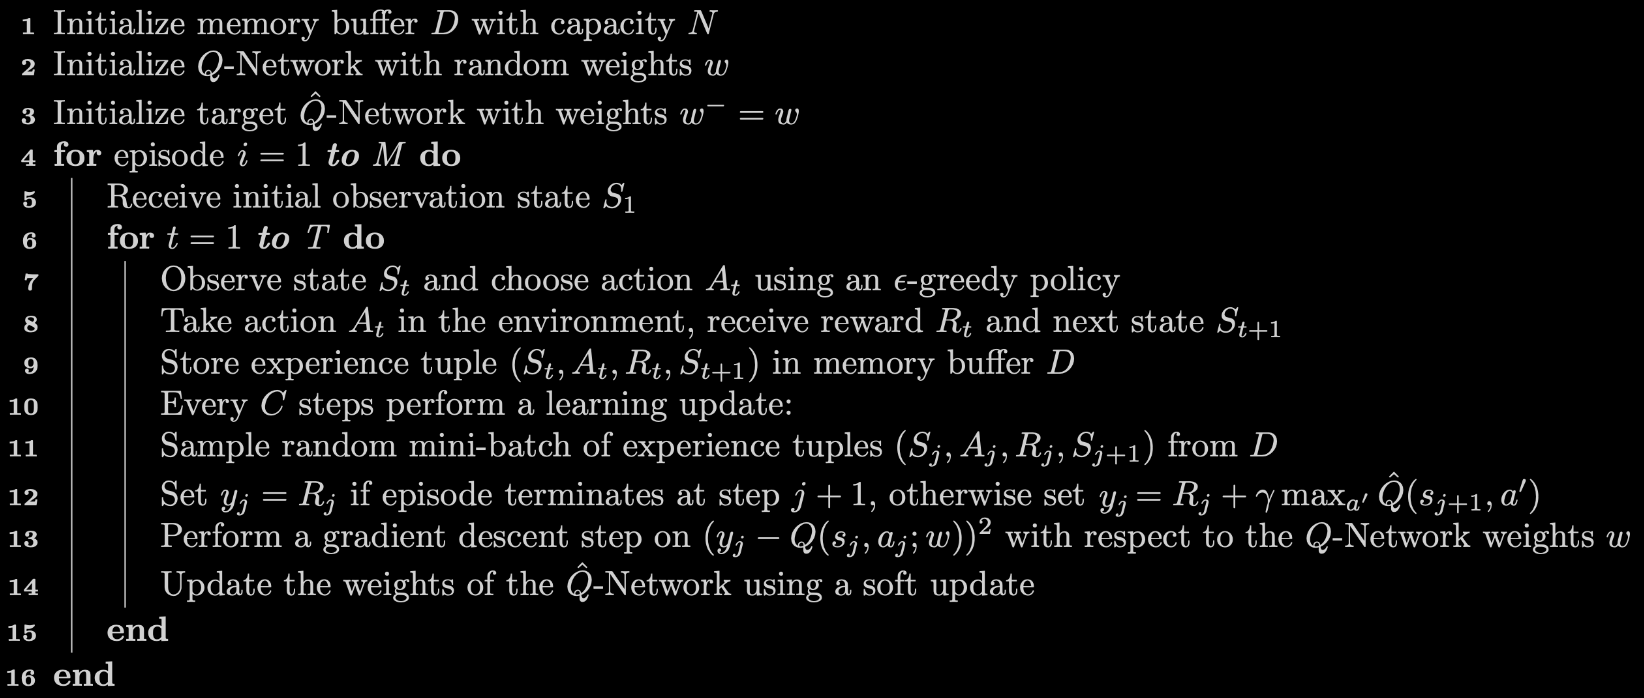

In [23]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
     #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    state = environment_reset_von_Jonas #JONAS HIER MUSS DEIN DINGS REIN
     #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
       #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'

        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
     #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        next_state, reward, done, _ = environment_next_step_von_Jonas(action)#JONAS HIER MUSS DEIN DINGS REIN
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
      #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
       #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

NameError: ignored